# Basic signal detection theory model

In [2]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np

import keras
import bayesflow as bf

from scipy.stats import norm

In this example we will fit a basic signal detection theory model:

where $h$, $f$ are the number of hit rates and false alarms, out of
$n_\text{signal}$ and $n_\text{noise}$ trials, respectively. We will
estimate the distriminability $d$ and bias $c$. During the inference
stage we will be also interested in the implied hit rate $\theta_h$ and
false alarm rate $\theta_f$.

### Simulator

Setting up the simulator is straightforward. We wish to be able to make
inferences for different numbers of trials, and so we will vary that as
a context variable.

In [3]:
def context():
    return dict(n = np.random.randint(low=5, high=120, size=2))

def prior():
    return dict(
        d = np.random.normal(0, np.sqrt(2)),
        c = np.random.normal(0, np.sqrt(1/2))
    )

def likelihood(d, c, n):
    # compute hit rate and false alarm rate:
    theta = norm.cdf([0.5 * d - c, - 0.5 * d - c])
    # simulate hits and false alarms
    x = np.random.binomial(n=n, p=theta, size=2)

    return dict(x=x)

simulator = bf.make_simulator([context, prior, likelihood])

### Approximator

We will use a `BasicWorkflow` object to wrap up all necessary networks.

In [6]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    inference_network=bf.networks.CouplingFlow(),
    inference_variables=["d", "c"],
    inference_conditions=["x", "n"]
)

### Training

In [ ]:
history = workflow.fit_online(epochs=50, num_batches_per_epoch=200, batch_size=256)

### Validation

{'losses': <Figure size 1600x400 with 1 Axes>,
 'recovery': <Figure size 1000x500 with 2 Axes>,
 'calibration_ecdf': <Figure size 1000x500 with 2 Axes>,
 'z_score_contraction': <Figure size 1000x500 with 2 Axes>}

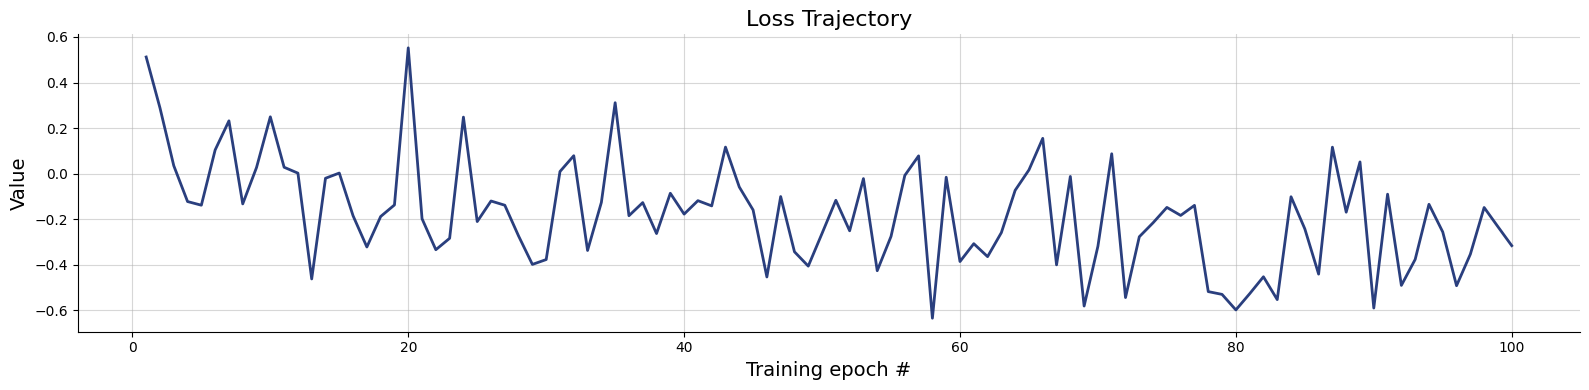

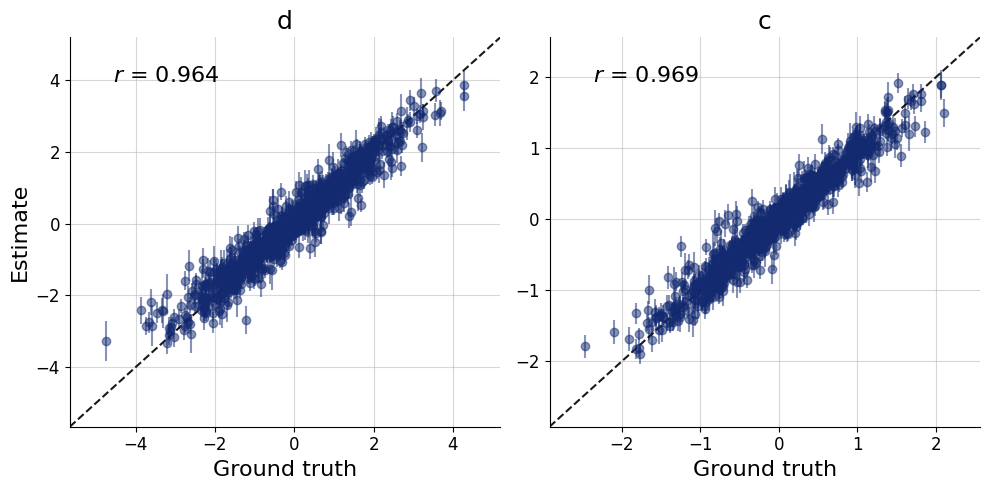

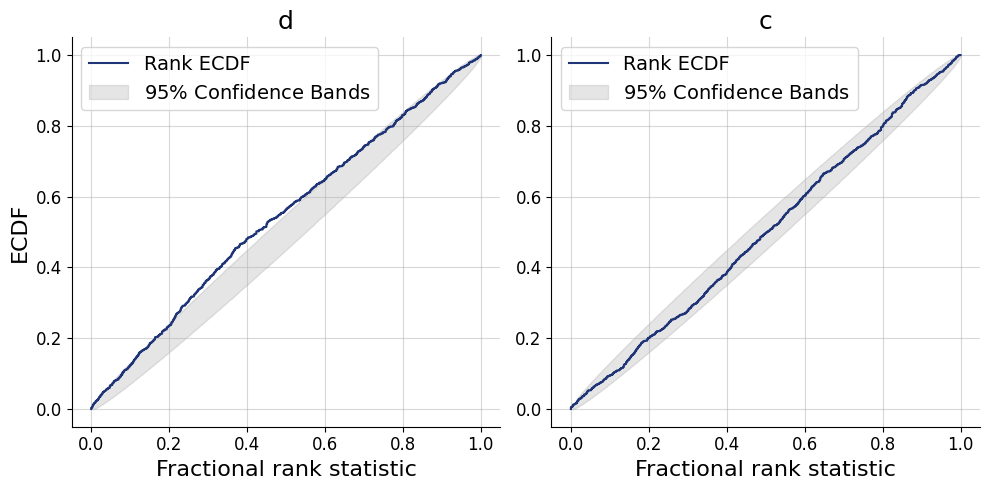

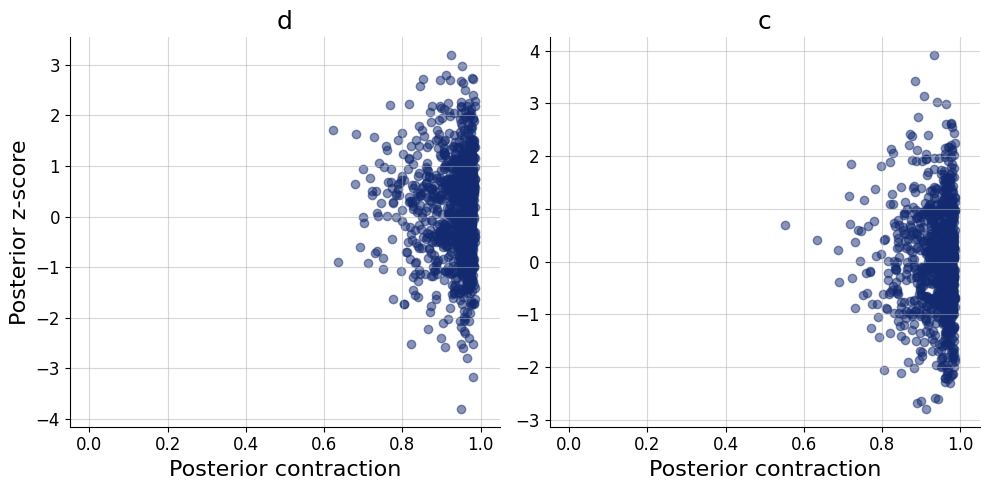

In [ ]:
test_data = simulator.sample(1000)

In [ ]:
figs = workflow.plot_default_diagnostics(test_data=test_data, num_samples=500)

### Inference

We are given three data sets (Lee & Wagenmakers, 2013):

1.  $h=70$, $f=50$, $n_{\text{signal}} = n_{\text{noise}} = 100$
2.  $h=7$, $f=5$, $n_{\text{signal}} = n_{\text{noise}} = 10$
3.  $h=10$, $f=0$, $n_{\text{signal}} = n_{\text{noise}} = 10$.

We can leverage the fact that we can make inferences for all three
datasets at the same time, we will get an array of the posterior samples
of $d$ and $c$ for each of the datasets.

In [37]:
inference_data = dict(
    x = np.array([
        [70, 50],
        [7, 5],
        [10, 0]
    ]),
    n = np.array([
        [100, 100],
        [10, 10],
        [10, 10]
    ])
)

posterior_samples = workflow.sample(conditions=inference_data, num_samples=1000)

In [38]:
def generated_quantities(c, d):
    return {
        "Discriminability": d,
        "Bias": c,
        "Hit rate": norm.cdf(0.5 * d - c),
        "False alarm": norm.cdf(-0.5 * d - c)
    }

posterior_samples = generated_quantities(**posterior_samples)

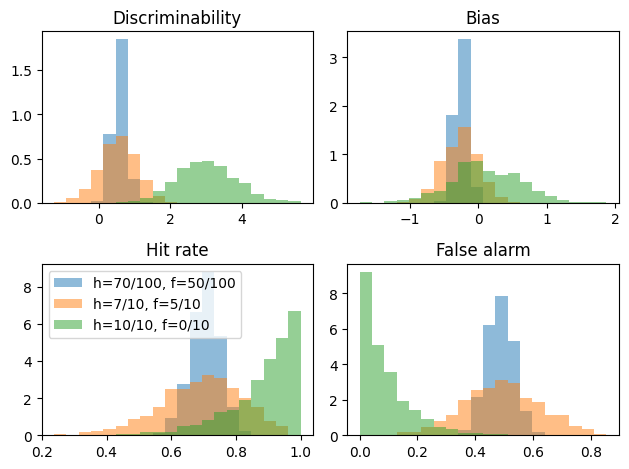

In [50]:
fig, axs = plt.subplots(2, 2)
axs=axs.flatten()

for index, (key, value) in enumerate(posterior_samples.items()):
    bins = np.histogram_bin_edges(value.ravel(), bins=20)
    for data_set in range(inference_data['x'].shape[0]):
        axs[index].hist(value[data_set].flatten(), alpha=0.5, density=True, bins=bins)
        axs[index].set_title(key)
axs[2].legend(['h=70/100, f=50/100', 'h=7/10, f=5/10', 'h=10/10, f=0/10'])
fig.tight_layout()


Lee, M. D., & Wagenmakers, E.-J. (2013). *Bayesian Cognitive Modeling: A
Practical Course*. Cambridge University Press.